1. Obtain cropped images from zarr file, max project them and save them back to the zarr file
Only need to run this cell once! Once the cropped images are saved as max projections go directly to the next cell.

In [37]:
import zarr
from tqdm import tqdm
import numpy as np


# Load zarr file
z= zarr.open("/mnt/efs/aimbl_2025/student_data/S-DD/LDM_treatments.zarr", mode="r")

# Explore zarr to find treatments and masks
def obtain_image_dataset_size(zarr_array):
    # Identify treatmens in the zarr file
    treatments = list(z.keys())
    print(f"Treatments found in zarr file: {treatments}")
    treatment_image_num = {}
    for treatment in treatments:
        image_num = z[treatment]['cimages_maskout'].shape[0]
        treatment_image_num[treatment] = image_num
        print(f"Image array for {treatment} has {image_num} images")
        image_shape = z[treatment]['cimages_maskout'][0].shape
        print(f"Image shape is: {image_shape}")
    return treatments, treatment_image_num
def max_project_images(treatments, z):
    # Load images into the numpy array
    for treatment in treatments:
        num_images = treatment_image_num[treatment]
        treatment_proj_array = np.zeros((num_images, 3, 128, 128), dtype=np.uint8)
        for i in tqdm(range(num_images), desc=f"Loading images for {treatment}"):
            image = z[treatment]['cimages_maskout'][i]
            treatment_proj_array[i] = np.max(image, axis=0)
            image = z[treatment]['cimages_maskout'][i]
            treatment_proj_array[i] = np.max(image, axis=0)
        print(f"Created array for treatment '{treatment}' with shape {treatment_proj_array.shape}")
  
        # Save the numpy array to the zarr file
        zarr.create_array(store="/mnt/efs/aimbl_2025/student_data/S-DD/LDM_treatments.zarr", name=f"{treatment}/cimages_max", data= treatment_proj_array, chunks=(1, 3, 128, 128))

treatments, treatment_image_num = obtain_image_dataset_size(z)
# for treatment in treatments:
#     print(f"Image number for treatment {treatment} is {treatment_image_num[treatment]}")
treatment_proj_array = max_project_images(treatments, z)

Treatments found in zarr file: ['8nMActD', 'DMSO', '1uMdoxo', 'CX5461', '5uMflavo', '800nMActD', '10uMmg132', '10uMwort']
Image array for 8nMActD has 1763 images
Image shape is: (15, 3, 128, 128)
Image array for DMSO has 2044 images
Image shape is: (15, 3, 128, 128)
Image array for 1uMdoxo has 1062 images
Image shape is: (15, 3, 128, 128)
Image array for CX5461 has 2189 images
Image shape is: (15, 3, 128, 128)
Image array for 5uMflavo has 1493 images
Image shape is: (15, 3, 128, 128)
Image array for 800nMActD has 1654 images
Image shape is: (15, 3, 128, 128)
Image array for 10uMmg132 has 1183 images
Image shape is: (15, 3, 128, 128)
Image array for 10uMwort has 1820 images
Image shape is: (15, 3, 128, 128)


Loading images for 8nMActD: 100%|██████████| 1763/1763 [06:12<00:00,  4.73it/s]


Created array for treatment '8nMActD' with shape (1763, 3, 128, 128)


Loading images for DMSO: 100%|██████████| 2044/2044 [07:40<00:00,  4.43it/s]


Created array for treatment 'DMSO' with shape (2044, 3, 128, 128)


Loading images for 1uMdoxo: 100%|██████████| 1062/1062 [02:22<00:00,  7.43it/s]


Created array for treatment '1uMdoxo' with shape (1062, 3, 128, 128)


Loading images for CX5461: 100%|██████████| 2189/2189 [08:14<00:00,  4.43it/s]


Created array for treatment 'CX5461' with shape (2189, 3, 128, 128)


Loading images for 5uMflavo: 100%|██████████| 1493/1493 [03:43<00:00,  6.69it/s]


Created array for treatment '5uMflavo' with shape (1493, 3, 128, 128)


Loading images for 800nMActD: 100%|██████████| 1654/1654 [05:49<00:00,  4.73it/s]


Created array for treatment '800nMActD' with shape (1654, 3, 128, 128)


Loading images for 10uMmg132: 100%|██████████| 1183/1183 [02:42<00:00,  7.26it/s]


Created array for treatment '10uMmg132' with shape (1183, 3, 128, 128)


Loading images for 10uMwort: 100%|██████████| 1820/1820 [06:28<00:00,  4.68it/s]


Created array for treatment '10uMwort' with shape (1820, 3, 128, 128)


Load images from zarr to torch dataset

In [71]:
import zarr
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import OneHotEncoder

class ZarrImageDataset(Dataset):
    def __init__(self, zarr_path, transform=None):
        self.root = zarr.open(zarr_path, mode='r')
        self.transform = transform
        self.images = []
        self.labels = []
        self.label_map = {name: idx for idx, name in enumerate(self.root.group_keys())}

        # Load images and labels
        # map treatments to integer labels
        for treatment_name in self.root.group_keys():
            treatment_group = self.root[treatment_name]['cimages_max']
            print(f"the treatment group shape is {treatment_group.shape}")
            for i in range(treatment_group.shape[0]):
                img = treatment_group[i]
                self.images.append(img)
                self.labels.append(self.label_map[treatment_name])
        # self.labels = np.array(self.labels).reshape(-1, 1)
        # enc = OneHotEncoder(categories=[['8nMActD', 'DMSO', '1uMdoxo', 'CX5461', '5uMflavo', '800nMActD', '10uMmg132', '10uMwort']]).fit(self.labels)
        # self.labels = enc.transform(self.labels).toarray()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        # Convert to torch tensor
        img_tensor = torch.tensor(img, dtype=torch.float32)
        label_tensor = torch.tensor(label, dtype=torch.long)

        if self.transform:
            img_tensor = self.transform(img_tensor)

        return img_tensor, label_tensor

# Call the function to create the dataset
zarr_path = '/mnt/efs/aimbl_2025/student_data/S-DD/LDM_treatments.zarr'
dataset = ZarrImageDataset(zarr_path)
# # Data loader
# loader = DataLoader(dataset, batch_size=32, shuffle=True)




the treatment group shape is (1183, 3, 128, 128)
the treatment group shape is (1062, 3, 128, 128)
the treatment group shape is (2044, 3, 128, 128)
the treatment group shape is (1493, 3, 128, 128)
the treatment group shape is (1820, 3, 128, 128)
the treatment group shape is (1654, 3, 128, 128)
the treatment group shape is (1763, 3, 128, 128)
the treatment group shape is (2189, 3, 128, 128)


In [60]:
#Test dataset
for i in range(20):
    img, label = dataset[i]
    print(f"Image {i} shape: {img.shape}, dtype: {img.dtype}")
    print(f"Label {i}: {label}")

Image shape is: (3, 128, 128)
Image 0 shape: torch.Size([3, 128, 128]), dtype: torch.float32
Label 0: tensor([0, 0, 0, 0, 0, 0, 1, 0])
Image shape is: (3, 128, 128)
Image 1 shape: torch.Size([3, 128, 128]), dtype: torch.float32
Label 1: tensor([0, 0, 0, 0, 0, 0, 1, 0])
Image shape is: (3, 128, 128)
Image 2 shape: torch.Size([3, 128, 128]), dtype: torch.float32
Label 2: tensor([0, 0, 0, 0, 0, 0, 1, 0])
Image shape is: (3, 128, 128)
Image 3 shape: torch.Size([3, 128, 128]), dtype: torch.float32
Label 3: tensor([0, 0, 0, 0, 0, 0, 1, 0])
Image shape is: (3, 128, 128)
Image 4 shape: torch.Size([3, 128, 128]), dtype: torch.float32
Label 4: tensor([0, 0, 0, 0, 0, 0, 1, 0])
Image shape is: (3, 128, 128)
Image 5 shape: torch.Size([3, 128, 128]), dtype: torch.float32
Label 5: tensor([0, 0, 0, 0, 0, 0, 1, 0])
Image shape is: (3, 128, 128)
Image 6 shape: torch.Size([3, 128, 128]), dtype: torch.float32
Label 6: tensor([0, 0, 0, 0, 0, 0, 1, 0])
Image shape is: (3, 128, 128)
Image 7 shape: torch.Size

Using ResNet18 as model

In [72]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pretrained ResNet-18 model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Modify the final fully connected layer and establish model parameters
num_epochs = 10
learning_rate = 0.001
batch_size = 32
num_classes = 8
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)
print(model)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

#Split dataset
# Total size of the dataset
total_size = len(dataset)

# Calculate split sizes
train_size = int(0.7 * total_size)
eval_size = int(0.2 * total_size)
test_size = total_size - train_size - eval_size  # Ensures full coverage

# Random split
train_dataset, eval_dataset, test_dataset = random_split(
    dataset,
    [train_size, eval_size, test_size],
    generator=torch.Generator().manual_seed(42))  # For reproducibility
print(f"The size of the train dataset is {len(train_dataset)}")
print(f"The size of the eval dataset is {len(eval_dataset)}")
print(f"The size of the test dataset is {len(test_dataset)}")

# Data loader

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Training loop

289it [00:10, 26.80it/s]


model trained


289it [00:10, 26.74it/s] [00:18<00:04, 27.43it/s]


model trained


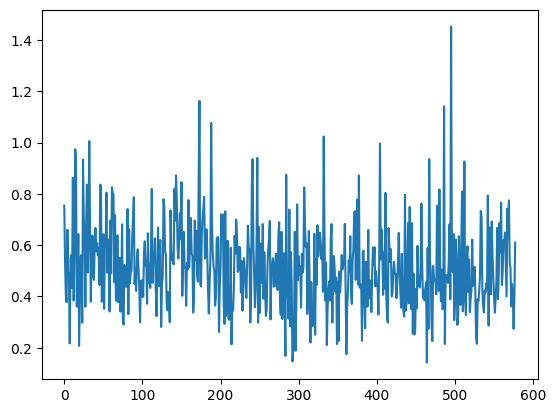

In [ ]:
import torch.nn.functional as F
# Training function:
def train_nucleoli_resnet(model, train_loader, batch_size, criterion, optimizer):
    model.train()
    pbar = tqdm(total=len(train_dataset) // batch_size)
    history = []
    for batch_idx, (raw, target) in enumerate(train_loader):
        optimizer.zero_grad()
        raw = raw.to(device)
        target = target.to(device)
        output = model(raw)
        # output_probabilities = F.softmax(output, dim=1)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        history.append(loss.item())
        pbar.update(1)
    return history

# Training loop:
loss_history = []
for epoch in range(2):
    his = train_nucleoli_resnet(model, train_loader, batch_size, criterion, optimizer)
    loss_history.extend(his)

fig, ax = plt.subplots()
ax.plot(loss_history)
fig.savefig('/mnt/efs/aimbl_2025/student_data/S-DD/nucleoli_restnet_trained_loss_plot.png')

# Save the model
torch.save(
        {"nucleoli_resnet": model.state_dict()}, '/mnt/efs/aimbl_2025/student_data/S-DD/nucleoli_restnet_trained.pth')

  0%|          | 0/288 [05:43<?, ?it/s]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x733decba9260>
Traceback (most recent call last):
  File "/home/S-DD/conda/envs/masketeers/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/S-DD/conda/envs/masketeers/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1628, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/S-DD/conda/envs/masketeers/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/S-DD/conda/envs/masketeers/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/S-DD/conda/envs/masketeers/lib/python3.11/multiprocessing/connection.py", line 948, in wait
    ready = selector.se

TypeError: Invalid shape (289,) for image data

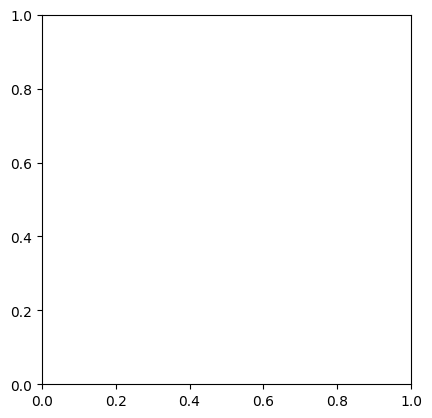

In [ ]:
#load weights to run predictions
weights = torch.load("/mnt/efs/aimbl_2025/student_data/S-DD/nucleoli_restnet_trained.pth")
model.load_state_dict(weights["nucleoli_resnet"])